In [1]:
import bt
import pandas as pd
import tradingeconomics as te
pd.set_option("display.max_rows",1000)


In [2]:
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
   ## bt.data.csv()
    return bt.Backtest(s, data)

class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    #data = bt.get(tickers, start=start)
    ##data = te.fetchMarkets(symbol=ticker, initDate='1991-01-01')
    data = pd.read_csv('histdata/stocks_psi_geral/minimal/{}-pl_daily_minimal.csv'.format(tickers), parse_dates=True, index_col=0)
    data.index.name = 'Date'
    data.columns = [tickers.split(':')[0]]
    data = data.iloc[::-1]
    #data = data.drop_duplicates()
    #data = bt.data.csv(tickers, path = 'histdata/stocks_psi_geral/minimal/{}_daily_minimal.csv'.format(tickers.replace(':','-')), parse_dates=True, index_col=0)
# df['date'] = df.index
   # print(df)
   # df = df.drop('symbol', axis=1)
    print(data.head())
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)


In [3]:
 class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            # print(self.tw)
            # print(self.tw.ix[target.now])
            # w = pd.DataFrame(w)
            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True
    

In [25]:
from bokeh.models import HoverTool, ColumnDataSource, BoxZoomTool
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import talib
output_notebook()
#output_file('ma_cross.html')

def ma_cross(ticker, start='2010-01-01', fitted_ma_period=9,  short_ma_period=19, long_ma_period=100, name='ma_cross'):
    # these are all the same steps as above
    #C:\Users\utilizador\PycharmProjects\tss\histdata\stocks_psi_geral\minimal\lig-pl_daily_minimal.csv
    data = pd.read_csv('C:\\Users\\utilizador\\PycharmProjects\\tss\\histdata\\stocks_psi_geral\\minimal\\{}_daily_minimal.csv'.format(ticker.replace(':','-')),
                           parse_dates=True, index_col=0)
    data = data[data.index > '2016-02-01']
    data.index.name = 'Date'
    data.columns = [ticker]
    data = data.iloc[::-1]
 
    fitted_ma = data.rolling(fitted_ma_period).mean()    
    short_ma = data.rolling(short_ma_period).mean()
    long_ma = data.rolling(long_ma_period).mean()
    #print(data.head())
    #fitted_ma = pd.DataFrame(talib.EMA(data[ticker].values, timeperiod=fitted_ma_period),index=data.index, columns=[ticker])
    #short_ma = pd.DataFrame(talib.EMA(data[ticker].values, timeperiod=short_ma_period),index=data.index, columns=[ticker])
    #long_ma = pd.DataFrame(talib.EMA(data[ticker].values, timeperiod=long_ma_period),index=data.index, columns=[ticker])
    #print(fitted_ma.head())
    plot = bt.merge(data, fitted_ma, short_ma, long_ma).plot(figsize=(15, 5))
    # self.data[ticker].columns = [ticker]
    
    # target weights
    tw = long_ma.copy()
    tw.columns = [ticker]
    tw[(short_ma > long_ma) & (fitted_ma > short_ma)] = 1.0
    tw[(short_ma < long_ma) | (fitted_ma < short_ma)] = 0.0
    tw[long_ma.isnull()] = 0.0
    for i in range(0,len(tw)):
        if tw[ticker].iloc[i] == 1.0:
            break
        elif tw[ticker].iloc[i] == -1.0:
            tw[ticker][i] = 0.0
               
    tmp = bt.merge(tw, data, fitted_ma, short_ma, long_ma)
    tmp.columns = ['tw', 'price', 'sma9', 'sma21', 'sma100']
    ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])
    
    tools = ['reset', 'box_select', 'pan', 'zoom_out', 'wheel_zoom']
    p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
    p1.line(tmp.index.values, tmp['sma100'].values, color='green', legend='sma100')
    
    p1.line(tmp.index.values, tmp['price'].values, color='brown', legend='price')
    p1.line(tmp.index.values, tmp['sma21'].values, color='orange', legend='sma21')
    p1.line(tmp.index.values, tmp['sma9'].values, color='red', legend='sma9')
    p1.extra_y_ranges = {"Weights": Range1d(start=0, end=1.0)}
    p1.add_layout(LinearAxis(y_range_name="Weights"), 'right')
    p1.line(tmp.index.values, tmp['tw'].values, color='purple', legend='tw', y_range_name="Weights")
    
    show(p1)

    
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance(), bt.algos.LimitWeights(limit=0.1)], [ticker])
    return bt.Backtest(s, data)




Loading BokehJS ...

galp_ma_cross
0% [############################# ] 100% | ETA: 00:00:00bcp_ma_cross
0% [############################# ] 100% | ETA: 00:00:00edp_ma_cross


C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


0% [############################# ] 100% | ETA: 00:00:00scp_ma_cross
0% [############################# ] 100% | ETA: 00:00:00

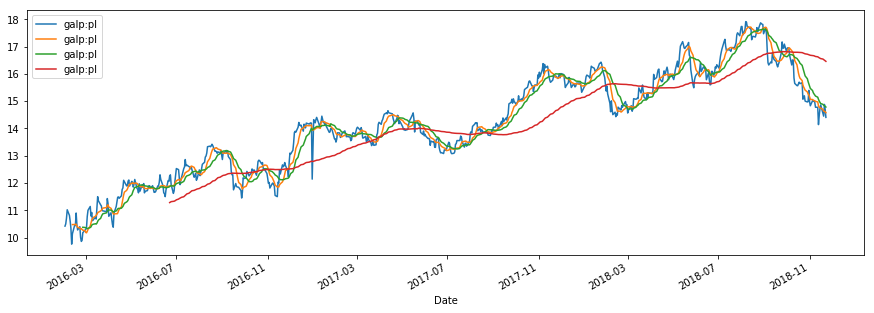

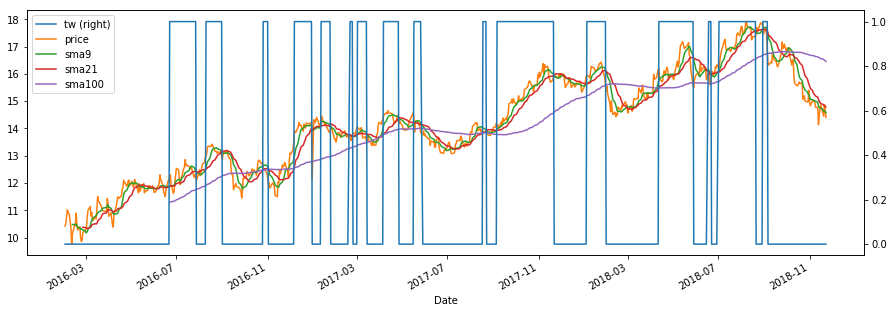

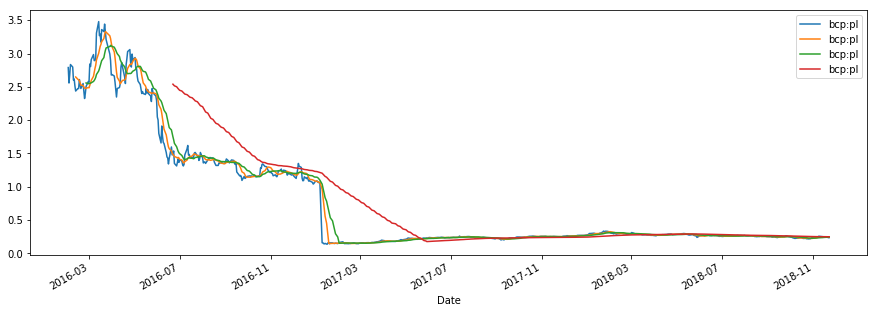

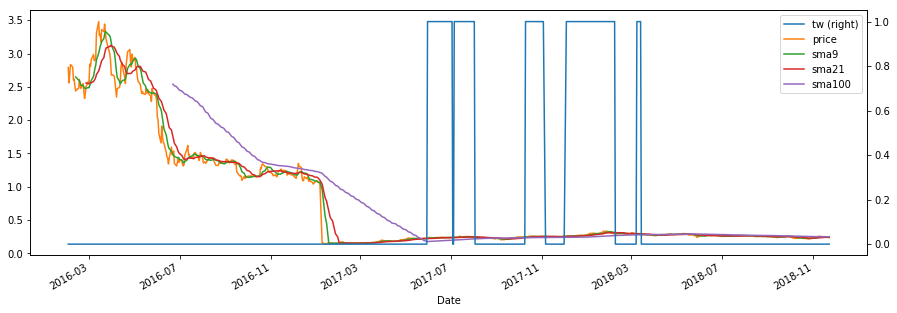

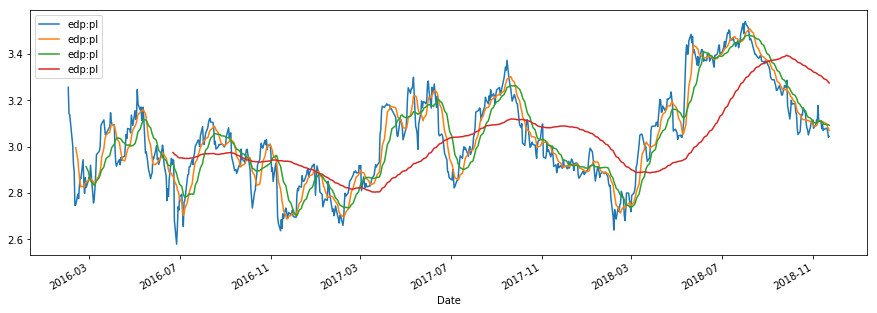

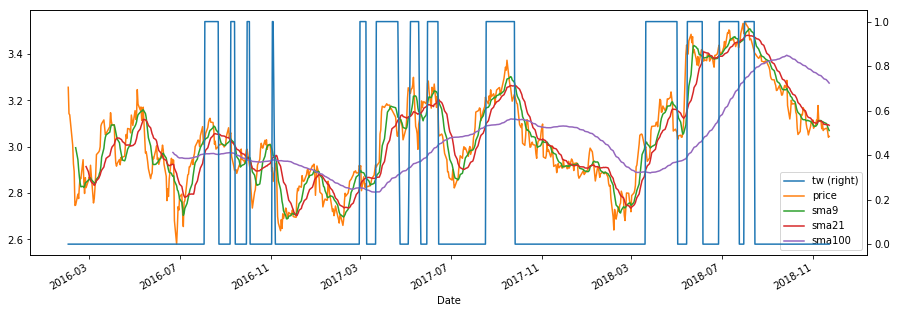

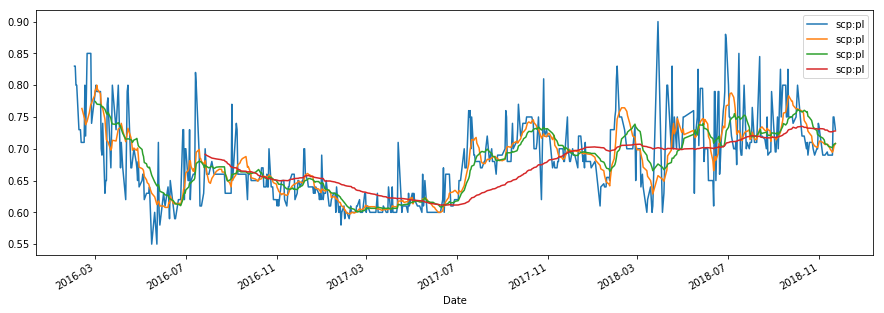

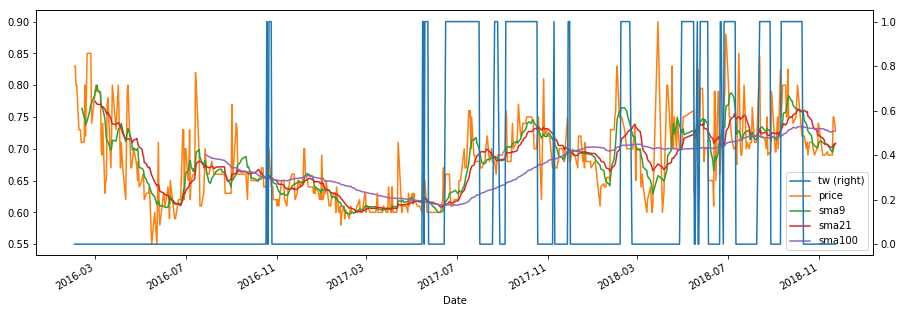

In [30]:
def run(selected_tickers, start=None, end=None):

    t1 = ma_cross('galp:pl', name='galp_ma_cross')
    t2 = ma_cross('bcp:pl', name='bcp_ma_cross')
    t3 = ma_cross('edp:pl', name='edp_ma_cross')
    t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2, t3, t4)
    

res = run(['galp:pl'])

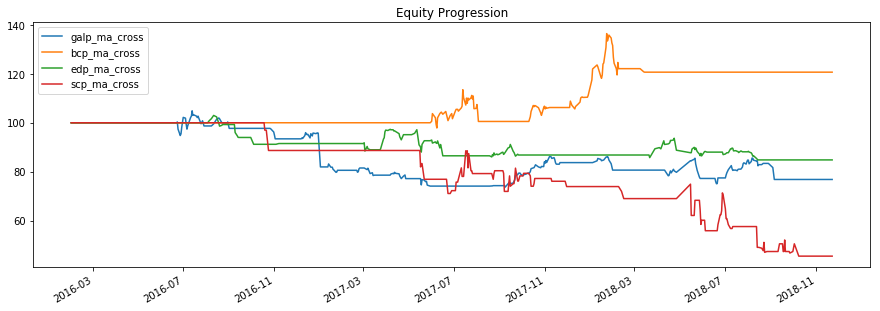

In [31]:
%matplotlib inline 
res.plot()

In [32]:
res.display()

Stat                 galp_ma_cross    bcp_ma_cross    edp_ma_cross    scp_ma_cross
-------------------  ---------------  --------------  --------------  --------------
Start                2016-02-01       2016-02-01      2016-02-01      2016-02-01
End                  2018-11-23       2018-11-23      2018-11-23      2018-11-23
Risk-free rate       0.00%            0.00%           0.00%           0.00%

Total Return         -23.20%          20.70%          -15.20%         -54.58%
Daily Sharpe         -0.63            0.68            -0.57           -0.81
Daily Sortino        -0.78            1.16            -0.76           -1.05
CAGR                 -8.97%           6.93%           -5.70%          -24.49%
Max Drawdown         -29.80%          -12.40%         -17.67%         -54.58%
Calmar Ratio         -0.30            0.56            -0.32           -0.45

MTD                  0.00%            0.00%           0.00%           0.00%
3m                   -7.89%           0.00%           